## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [1]:
%matplotlib widget

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import preprocessing

from generate_TF import GenerateTF, get_freq
from scipy.optimize import curve_fit
from prettytable import PrettyTable

from pytorchClassifiers import get_keras_nn

avg_pool1d = keras.layers.AveragePooling1D



2022-08-01 15:59:01.587136: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-01 15:59:01.600062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-08-01 15:59:01.600087: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load the data
df = pd.read_pickle('./data/tf-ampl-response-82000-noise0.1.pkl')
df.head()

,phase,gain,fmax,np,amplitude,real,imag
0,-20.0,0.001000,1.619443e+06,662,"[-23.357375491745664, -26.0851996017893, -33.5...","[-0.021054299508294433, 0.011429574087198234, ...","[-0.06459629148257023, -0.048295480826260104, ..."
1,-20.0,0.001076,1.619443e+06,662,"[-25.511325980758013, -24.718449487385854, -22...","[0.03595637676979386, 0.02166354899835697, 0.0...","[-0.038963847424329734, -0.05389590082010029, ..."
2,-20.0,0.001157,1.619443e+06,662,"[-28.81491896127936, -27.827786179958505, -22....","[0.029248474226871202, -0.0010979300410257227,...","[-0.021407072762403726, -0.040593069698999486,..."
3,-20.0,0.001245,1.619443e+06,662,"[-22.070854131154633, -30.845860065171713, -30...","[0.04974268693060286, 0.0186999550411898, 0.00...","[-0.061099382076756276, -0.02175634418295811, ..."
4,-20.0,0.001339,1.619443e+06,662,"[-20.804871672297395, -21.592750057670216, -21...","[-0.061915548957550866, -0.018752193856578357,...","[-0.06689377758231763, -0.08110624967159283, -..."


In [3]:
# Extract the target variables
phase = df.pop('phase')
gain = df.pop('gain')

# All fmax, np should be equal
fmax = df.iloc[0].fmax
NP = df.iloc[0].np
df.drop(columns=['fmax', 'np'], inplace=True)

In [4]:
# target_orig is the vector with the originale phase, gain labels
target_orig = np.array((phase, gain), dtype=np.float32).T

target_scaler = preprocessing.StandardScaler().fit(target_orig)
# target is scaled, better for training
target = target_scaler.transform(target_orig)


In [5]:
# our dataset is 3D
values = np.zeros((len(df), len(df.iloc[0].real), 3), dtype=np.float32)
print(values.shape)
for index, row in df.iterrows():
    # print(row)
    values[index, :, 0] = row.real
    values[index, :, 1] = row.imag
    values[index, :, 2] = row.amplitude
data = values

(82000, 662, 3)


In [6]:
# Split in train and test
X_train_orig, X_test_orig, y_train, y_test, y_train_orig, y_test_orig = train_test_split(
    data, target, target_orig, test_size=0.2, random_state=0)

# further divide X_test in test + validate
X_test_orig, X_validate_orig, y_test, y_validate, y_test_orig, y_validate_orig = \
    train_test_split(X_test_orig, y_test, y_test_orig, test_size=0.4, random_state=1)

X_train = X_train_orig[:, :, :2]
X_test = X_test_orig[:, :, :2]
X_validate = X_validate_orig[:, :, :2]

print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validate.shape)


(65600, 662, 2)
(9840, 662, 2)
(6560, 662, 2)
(65600, 2)
(9840, 2)
(6560, 2)


In [7]:
# load the models
model1 = keras.models.load_model('models/keras/regression/phase_best')
model2 = keras.models.load_model('models/keras/regression/gain_best')


2022-08-01 15:59:10.456753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-08-01 15:59:10.456945: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-01 15:59:10.456962: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2022-08-01 15:59:10.457435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def curve_fit_deluxe(func, freq, sample, trim_edges=0, kernel_size=1, stride=1, **kwargs):
    # center crop sample
    if trim_edges > 0:
        freq, sample = freq[trim_edges:-trim_edges], sample[trim_edges:-trim_edges]
    # prepare the shapes for avg_pooling
    freq = freq.reshape(1, -1, 1)
    sample = sample.reshape(1, -1, 1)
    # perform average pooling
    freq = avg_pool1d(pool_size=kernel_size, strides=stride)(freq).numpy().flatten()
    sample = avg_pool1d(pool_size=kernel_size, strides=stride)(sample).numpy().flatten()
    # pass to curve_fit
    return curve_fit(func, freq, sample, **kwargs)

In [9]:
# Get curve fit predictions
gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
freq = gen_tf.frequency.astype(np.float32)
y_optimizer = []
for sample in X_validate_orig[:, :, 2]:
    popt, _ = curve_fit_deluxe(gen_tf, freq, sample, trim_edges=130, kernel_size=4, stride=1,
                               bounds=([-20, 1e-4], [20, 1e-2]), method='trf')
    y_optimizer.append(popt)
y_optimizer = np.array(y_optimizer)


In [10]:
# Get model's predictions
y_nn_phase = model1.predict(X_validate).flatten()
y_nn_gain = model2.predict(X_validate).flatten()
y_nn = np.array([y_nn_phase, y_nn_gain]).T


205/205 [==============================] - 0s 1ms/step


In [11]:
# Descale predictions
y_nn_descaled = target_scaler.inverse_transform(y_nn)
y_nn_phase_descaled = y_nn_descaled[:, 0]
y_nn_gain_descaled = y_nn_descaled[:, 1]

phase_loss = model1.evaluate(X_validate, y_validate[:, 0])
gain_loss = model2.evaluate(X_validate, y_validate[:, 1])


205/205 [==============================] - 0s 1ms/step - loss: 8.0097e-05


In [12]:
# I want to make a heatmap, x axis phase, y axis gain, z: accuracy
phase_values = np.unique(target_orig[:, 0]).tolist()
gain_values = np.unique(target_orig[:, 1]).tolist()

# Z phase shows the correctly predicted phase per gain
z_phase = np.zeros((2, len(gain_values)), dtype=float)
# Z gain shows the correctly predicted phase per phase
z_gain = np.zeros((2, len(phase_values)), dtype=float)

# Z phase shows the correctly predicted phase per gain
z_phase_opt = np.zeros((2, len(gain_values)), dtype=float)
# Z gain shows the correctly predicted phase per phase
z_gain_opt = np.zeros((2, len(phase_values)), dtype=float)

# Tolerance for phase: 0.5
# tolerance for gain: 0.0001
phase_tol = 0.5
gain_tol = 0.0001

for i in range(len(X_validate)):
    true_p, true_g = y_validate_orig[i]
    pred_p, pred_g = y_nn_descaled[i]
    opt_p, opt_g = y_optimizer[i]

    z_phase[1][gain_values.index(true_g)] += 1
    # Increase by 1 if predicted phase is equal to true phase
    z_phase[0][gain_values.index(true_g)] += np.abs(true_p - pred_p) < phase_tol

    z_gain[1][phase_values.index(true_p)] += 1
    z_gain[0][phase_values.index(true_p)] += np.abs(true_g - pred_g) < gain_tol

    z_phase_opt[1][gain_values.index(true_g)] += 1
    # Increase by 1 if predicted phase is equal to true phase
    z_phase_opt[0][gain_values.index(true_g)] += np.abs(true_p - opt_p) < phase_tol

    z_gain_opt[1][phase_values.index(true_p)] += 1
    z_gain_opt[0][phase_values.index(true_p)] += np.abs(true_g - opt_g) < gain_tol



phase_acc_nn = np.sum(z_phase[0]) / np.sum(z_phase[1])
gain_acc_nn = np.sum(z_gain[0]) / np.sum(z_gain[1])
z_phase[0] /= z_phase[1]
z_gain[0] /= z_gain[1]

phase_acc_opt = np.sum(z_phase_opt[0]) / np.sum(z_phase_opt[1])
gain_acc_opt = np.sum(z_gain_opt[0]) / np.sum(z_gain_opt[1])
z_phase_opt[0] /= z_phase_opt[1]
z_gain_opt[0] /= z_gain_opt[1]


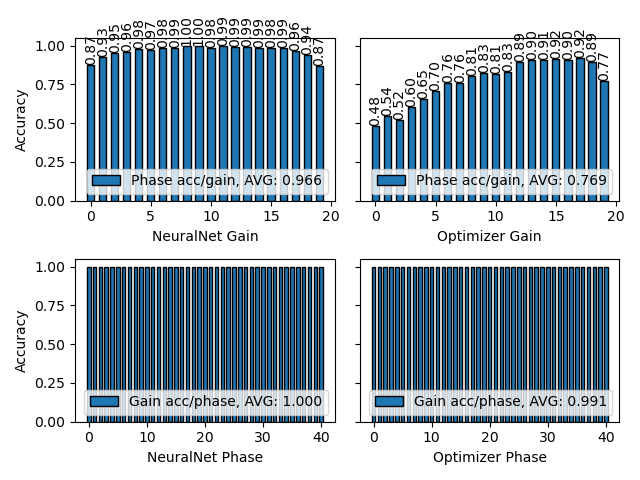

In [13]:
import matplotlib.pyplot as plt

fig, (ax_arr) = plt.subplots(nrows=2, ncols=2, sharey=True)

plt.sca(ax_arr[0, 0])
bars = plt.bar(np.arange(len(gain_values)), z_phase[0], width=0.6, edgecolor='black', color='tab:blue',
               label=f'Phase acc/gain, AVG: {phase_acc_nn:.3f}')
plt.gca().bar_label(bars, fmt='%.2f', rotation='vertical')
plt.ylim(0, 1.05)
plt.xlabel('NeuralNet Gain')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.sca(ax_arr[0, 1])
bars = plt.bar(np.arange(len(gain_values)), z_phase_opt[0], width=0.6, edgecolor='black', color='tab:blue',
               label=f'Phase acc/gain, AVG: {phase_acc_opt:.3f}')
plt.gca().bar_label(bars, fmt='%.2f', rotation='vertical')
plt.ylim(0, 1.05)
plt.xlabel('Optimizer Gain')
# plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.sca(ax_arr[1, 0])
plt.bar(np.arange(len(z_gain[0])), z_gain[0], width=0.6, edgecolor='black', color='tab:blue',
        label=f'Gain acc/phase, AVG: {gain_acc_nn:.3f}')
plt.ylim(0, 1.05)
plt.xlabel('NeuralNet Phase')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()

plt.sca(ax_arr[1, 1])
plt.bar(np.arange(len(z_gain[0])), z_gain[0], width=0.6, edgecolor='black', color='tab:blue',
        label=f'Gain acc/phase, AVG: {gain_acc_opt:.3f}')
plt.ylim(0, 1.05)
plt.xlabel('Optimizer Phase')
# plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()


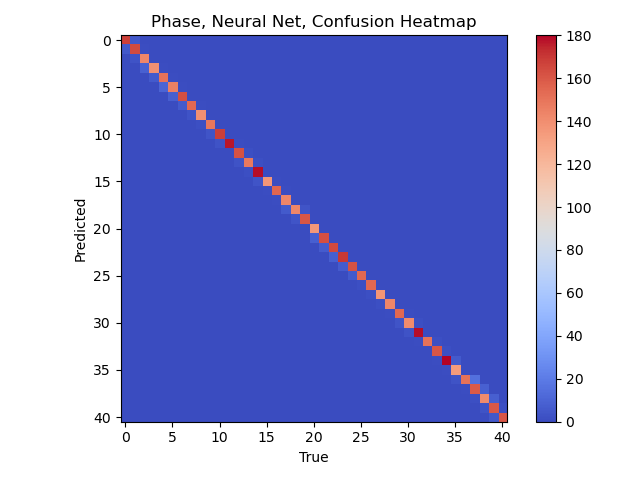

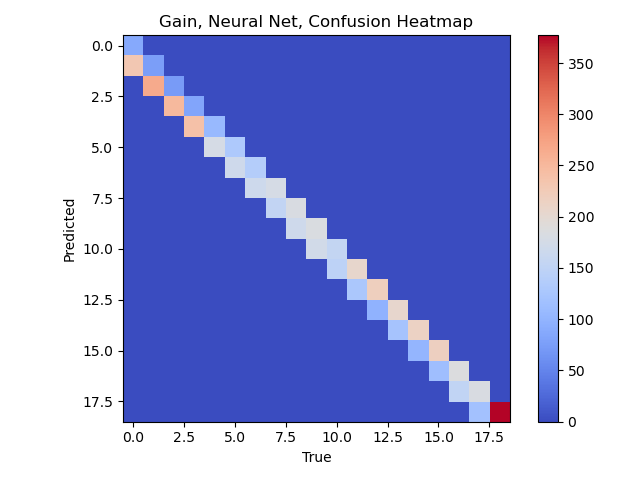

In [14]:
phase_orig = y_validate_orig[:, 0]
phase_pred = y_nn_descaled[:, 0]

bins = np.array(phase_values+[phase_values[-1]+1]) - 0.5
h, xedges, yedges = np.histogram2d(phase_orig, phase_pred, bins=bins,
                                   density=False)

fig = plt.figure()
plt.title('Phase, Neural Net, Confusion Heatmap')
im0 = plt.imshow(h, cmap='coolwarm')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.colorbar(im0, ax=plt.gca())
plt.tight_layout()

gain_orig = y_validate_orig[:, 1]
gain_pred = y_nn_descaled[:, 1]

# bins = np.array(gain_values+[gain_values[-1]+0.001]) - 0.
h, xedges, yedges = np.histogram2d(gain_orig, gain_pred, bins=gain_values,
                                   density=False)

fig = plt.figure()
plt.title('Gain, Neural Net, Confusion Heatmap')
im1 = plt.imshow(h, cmap='coolwarm')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.colorbar(im1, ax=plt.gca())
plt.tight_layout()


In [15]:
from sklearn.metrics import r2_score, mean_squared_error

r2_nn = r2_score(y_validate_orig, y_nn_descaled,
                   multioutput='raw_values')
mse_nn = mean_squared_error(y_validate_orig, y_nn_descaled,
                               multioutput='raw_values')

r2_opt = r2_score(y_validate_orig, y_optimizer,
                  multioutput='raw_values')
mse_opt = mean_squared_error(y_validate_orig, y_optimizer,
                              multioutput='raw_values')

print('R2\tPhase\tGain')
print('NeuralNet: ', r2_nn)
print('Optimizer:', r2_opt)

print('MSE\tPhase\tGain')
print('NeuralNet: ', mse_nn)
print('Optimizer:', mse_opt)



R2	Phase	Gain
NeuralNet:  [0.99960904 0.99991834]
Optimizer: [0.99789758 0.99392106]
MSE	Phase	Gain
NeuralNet:  [5.5199992e-02 6.5173082e-11]
Optimizer: [2.96844612e-01 4.85191874e-09]


In [ ]:
plt.figure(figsize=(7, 6))

table = PrettyTable()
table.field_names = ["idx", "param", "original", "NN", "Opt"]

gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
freq = gen_tf.frequency.astype(np.float32)

for idx in np.random.choice(np.arange(0, len(X_validate)), size=3):
    try:
        popt, _ = curve_fit_deluxe(gen_tf, freq, X_validate_orig[idx, :, 2], trim_edges=130, kernel_size=4, stride=1,
                                   bounds=([-20, 1e-4], [20, 1e-2]), method='trf')
    except:
        print(f'Scipy curve fit failed for idx: {idx}')
        continue

    table.add_row([idx, 'phase', y_validate_orig[idx]
                  [0], y_nn_descaled[idx][0], popt[0]])
    table.add_row([idx, 'gain', y_validate_orig[idx][1],
                  y_nn_descaled[idx][1], popt[1]])

    p = plt.plot(
        freq, gen_tf(freq, *(y_validate_orig[idx])), label=f'real_{idx}', ls='-')
    plt.plot(freq, gen_tf(
        freq, *(y_nn_descaled[idx])), label=f'NN_{idx}', ls='--', color=p[0].get_color())
    plt.plot(freq, gen_tf(freq, *popt),
             label=f'opt_{idx}', ls=':', color=p[0].get_color())
    # plt.plot(x, gen_tf(x, *poptModel), label=f'opt+model_{idx}', ls='-.', color=p[0].get_color())
print(table)
plt.legend(ncol=3)
plt.tight_layout()
